# 그랩컷으로 추출한 객체 경계 마스크를 후처리해서 아름답게 바꾸기
- 1.모폴리지 연산 : 노이즈제거, 작은 구멍들 없애기 => 흡족함
- 2.경계선 평활화 : 복잡한 경계를 단순화 해준다, +흑백만 사용해서 노이즈예방 => 아주 나이스함
- 위에것들을 합치고 저장할때 리사이징하기 => 완료
 - 방안1: cv2.INTER_AREA 리사이징 후 => cv2.THRESH_BINARY 이진화처리 => 중간에 흑백이 아닌 픽셀이 생겨남
 - 방안2: 이진화 처리 후 => cv2.INTER_AREA 리사이징하기 =>안티앨리어싱 현상생김
 - 방안3: cv2.INTER_NEAREST 리사이징기법 사용 => 흑백으로 잘나오면서 경계도 비교적 잘유지하는듯함, 흡족

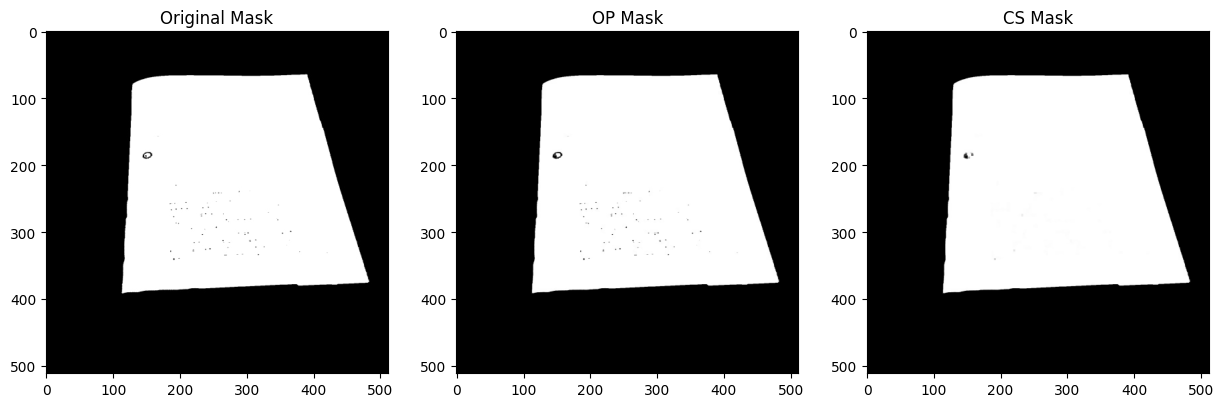

In [5]:
# 작은 점같은거 없애기, 모폴로지 연산으로 노이즈 제거
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 마스크 이미지 불러오기
mask = cv2.imread('./seg/KakaoTalk_20240213_090413133.jpg', 0)

# 커널 크기
kernel = np.ones((3,3), np.uint8)
# Opening 연산으로 노이즈 제거
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Closing 연산으로 작은 구멍 메우기
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

# 결과 표시
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('OP Mask')
plt.imshow(opening, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('CS Mask')
plt.imshow(closing, cmap='gray')
# cv2.imshow('Original Mask', mask)
# cv2.imshow('After Opening', opening)
# cv2.imshow('After Closing', closing)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

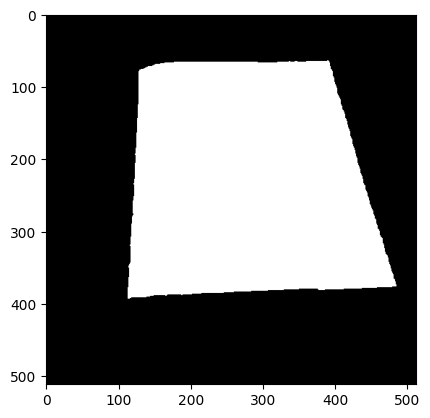

In [9]:
# 경계선 평활화 사용
# 모폴로지 끝난걸 가지고 해야됨 
contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 각 컨투어에 대해 근사화를 수행하고 마스크에 그린다
smooth_mask = np.zeros_like(closing)
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.0005*cv2.arcLength(cnt, True), True)
    cv2.drawContours(smooth_mask, [approx], 0, (255), thickness=cv2.FILLED)

plt.imshow(smooth_mask, cmap='gray')

# # 원본 이미지 랑 결합 해야뎀 
# image = cv2.imread('original_image.jpg')

# # 후처리된 마스크를 사용하여 이미지에서 전경 추출
img = cv2.imread('./org/KakaoTalk_20240213_090413133.jpg')
foreground = cv2.bitwise_and(img, img, mask=smooth_mask)

cv2.imshow('Extracted Foreground', foreground)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
# 위에 기능들 합쳐서 넣기
import sys
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

import tkinter as tk
from tkinter import filedialog

# image_path= './img_data/2QzDgg_3.png'

Blue,Green,Red,Black,White = (255,0,0),(0,255,0),(0,0,255),(0,0,0),(255,255,255)
DRAW_BG = {'color':Black,'val':0}
DRAW_FG = {'color':White,'val':1}

rect = (0,0,1,1)
drawing = False
rectangle = False
rect_over = False
rect_or_mask = 100
value = DRAW_FG
thickness = 11

# 이전 상태를 저장하기 위한 변수
prev_img = None
prev_mask = None

def onMouse(event,x,y,flags,params):
    global ix, iy, img, img2, drawing, value, mask,rectangle
    global rect, rect_or_mask,rect_over, thickness
    
    # 연필 크기 보기
    if event == cv2.EVENT_MOUSEMOVE and not drawing:
        img = img2.copy()
        # 현재 마우스 위치에 따라 원을 그립니다. 이 원은 현재 thickness 값을 반영합니다.
        cv2.circle(img, (x, y), thickness, (0, 0, 255), 2)  # 마우스 위치에 원을 그림

    if event == cv2.EVENT_RBUTTONDOWN:
        rectangle = True
        ix,iy = x,y

    elif event == cv2.EVENT_MOUSEMOVE:
        if rectangle:
            img = img2.copy()
            cv2.rectangle(img,(ix,iy),(x,y),Red,2)
            rect = (min(ix,x),min(iy,y),abs(ix-x),abs(iy-y))
            rect_or_mask = 0

    elif event == cv2.EVENT_RBUTTONUP:
        rectangle = False
        rect_over = True

        cv2.rectangle(img,(ix,iy),(x,y),Red,2)
        rect = (min(ix,x),min(iy,y),abs(ix-x),abs(iy-y))
        rect_or_mask = 0
        print('n:적용하기')

    if event == cv2.EVENT_LBUTTONDOWN:
        if not rect_over:
            print('마우스 왼쪽을 누른채로 전경이 되는 부분을 선택하시오')
        else:
            drawing = True
            cv2.circle(img,(x,y),thickness,value['color'],-1)
            cv2.circle(mask,(x,y),thickness,value['val'],-1)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.circle(img,(x,y),thickness,value['color'],-1)
            cv2.circle(mask,(x,y),thickness,value['val'],-1)

    elif event == cv2.EVENT_LBUTTONUP:
        if drawing:
            drawing = False
            cv2.circle(img,(x,y),thickness,value['color'],-1)
            cv2.circle(mask,(x,y),thickness,value['val'],-1)
    return


def grapcut(image_path):
    global ix, iy, img, img2, drawing, value, mask,rectangle
    global rect, rect_or_mask,rect_over, thickness
    global prev_img, prev_mask

    img = cv2.imread(image_path)
    img2 = img.copy()
    
    # 흑백이아닌 마스크이다
    mask = np.zeros(img.shape[:2],dtype=np.uint8)
    output = np.zeros(img.shape,np.uint8)


    cv2.namedWindow('input', cv2.WINDOW_NORMAL)
    cv2.namedWindow('output', cv2.WINDOW_NORMAL)
    cv2.namedWindow('mask', cv2.WINDOW_NORMAL)
    cv2.setMouseCallback('input',onMouse,param=(img,img2))
    cv2.moveWindow('input',img.shape[1]+10,90)

    print('오른쪽 마우스 버튼을 누르고 영역을 지정한 후 n을 누르시오')

    while True:
        cv2.imshow('output',output)
        cv2.imshow('input',img)

        k = cv2.waitKey(1) & 0xFF
        
        # esc키누르면 종료
        if k == 27:  
            exit()
            break
        # '+' 키를 누르면 thickness 증가
        if k == ord(']'):
            thickness += 3
            print(f'현재 두께: {thickness}')

        # '-' 키를 누르면 thickness 감소, 단, thickness는 1보다 작아질 수 없음
        if k == ord('[') and thickness > 1:
            thickness -= 3
            print(f'현재 두께: {thickness}')

        if k == ord('0'):
            print('왼쪽 마우스로 제거할 부분을 표시한 후 n을 누르세요')
            value = DRAW_BG
        if k == ord('1'):
            print('왼쪽 마우스로 복원할 부분을 표시한 후 n을 누르세요')
            value = DRAW_FG
        if k == ord('r'):
            print('리셋합니다')
            rect = (0,0,1,1)
            drawing = False
            rectangle = False
            rect_or_mask = 100
            rect_over = False
            value = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2],dtype=uint8)
            output = np.zeros(img.shape,np.uint8)
            print('0:제거할 배경선택, 1:복원할 전경선택, n:적용하기, r:리셋')
        elif k == ord('n'):
            # 'n' 키를 누르기 전 상태 저장
            prev_img = img2.copy()
            prev_mask = mask.copy()
            
            bgdModel = np.zeros((1,65),np.float64)
            fgdModel = np.zeros((1,65),np.float64)

            if rect_or_mask == 0:
                cv2.grabCut(img2,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_RECT)
                rect_or_mask = 1
            elif rect_or_mask == 1:
                cv2.grabCut(img2,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_MASK)

            print('0:제거할 배경선택, 1:복원할 전경선택, n:적용하기')
            print('s:저장 후 계속, r:리셋, b:되돌리기, esc:완전종료')
            print('크기조절 키우기 ], 줄이기 [')
            
            # 업데이트된 마스크를 흑백으로 변환하여 mask2에 저장
            mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8') * 255
            
            # 커널 크기
            kernel = np.ones((4,4), np.uint8)
            # Opening 연산으로 노이즈 제거
            opening = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, kernel)
            # Closing 연산으로 작은 구멍 메우기 
            closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
            
            # 경계선 평활화
            # 경계를 찾는다
            contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            # 각 컨투어에 대해 근사화를 수행하고 마스크에 그린다
            # mask2로 저장한다 
            mask2 = np.zeros_like(closing)
            for cnt in contours:   
                #approxPolyDP의 두번째 매개변수를 적절히 조절하면 경계가 단순화된다
                approx = cv2.approxPolyDP(cnt, 0.001*cv2.arcLength(cnt, True), True)
                # 흑백만 걸러서 노이즈 방지
                cv2.drawContours(mask2, [approx], 0, (255), thickness=cv2.FILLED)

            # mask2를 'mask' 윈도우에 표시
            cv2.imshow('mask', mask2)
            
            # 저장하기누르면 현재 창에보이는 결과물이 저장됨 
            saved_mask = mask2.copy()
            # 전경을 마스크를 기반으로 다시 추출해준다
            # 후처리된 마스크를 사용하여 이미지에서 전경 추출
            output = cv2.bitwise_and(img2, img2, mask=mask2)
        
        # 이전 적용상태로 되돌리기
        elif k == ord('b'):  # 'b' 키를 눌러 이전 상태로 되돌리기
            if prev_img is not None and prev_mask is not None:
                img2 = prev_img.copy()
                mask = prev_mask.copy()
                print("이전 상태로 되돌렸습니다.")
                # 이전 마스크를 기반으로 출력 이미지 업데이트
                mask2 = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
                output = cv2.bitwise_and(img2, img2, mask=mask2)
                # 변경된 상태를 'input' 및 'output' 윈도우에 표시
                cv2.imshow('input', img2)
                cv2.imshow('output', output)
            
        # 여기에 적당한 마스크 확인 했으면 저장하는 기능 추가해야됨 
        elif k == ord('s'):  # 's' 키를 누르면 실행
            #원본 파일이름과맞추기기
            filename, file_extension = os.path.splitext(os.path.basename(image_path))
            output_path = os.path.join('./seg', filename + file_extension)
            
            # 저장경로 잇는지 확인
            if not os.path.exists('./seg'):
                os.makedirs('./seg')

            # 사이즈 바꾸기
            saved_mask = cv2.resize(saved_mask, (512, 512), interpolation=cv2.INTER_NEAREST)
            # 마스크 저장
            cv2.imwrite(output_path, saved_mask)
            print(f'마스크 이미지를 {output_path}로 저장했습니다.')
            
            # org 변환해서 저장
            output_path = os.path.join('./org', filename + file_extension)
            if not os.path.exists('./org'):
                os.makedirs('./org')
                
            img2 = cv2.resize(img2, (512, 512), interpolation=cv2.INTER_AREA)
            cv2.imwrite(output_path, img2)
            print(f'오리지날 이미지를 {output_path}로 저장했습니다.')
            break
            
            ###새로운 이미지를 불러오기위해 파일선택창을 띄우는 기능을 
            ### 추가해야뎀
            
            
        # 전경을 흑백으로 추출
        # mask2 = np.where((mask==1) + (mask == 3),255,0).astype('uint8')
        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8') * 255
        output = cv2.bitwise_and(img2,img2,mask=mask2)

    cv2.destroyAllWindows()
    
    
# 파일선택창    
def select_image_file():
    root = tk.Tk()
    root.withdraw()  # Tkinter 창을 띄우지 않고 파일 선택 대화 상자만 사용
    file_path = filedialog.askopenfilename()  # 파일 선택 창을 띄움
    return file_path

# 이미지 선택해서 경로 가지고와서 그랩컷 실행
def load_and_process_image():
    while True:
        image_path = select_image_file()
        if image_path:  # 사용자가 파일을 선택한 경우
            # 현재 작업 디렉토리의 절대 경로
            current_dir = os.path.abspath(os.getcwd())  
            # 상대 경로 계산
            relative_path = os.path.relpath(image_path, current_dir)  
            print(f"선택된 파일: {image_path}")
            grapcut(relative_path)  # 선택된 이미지에 대해 grapcut 함수 실행
        else:
            print("파일이 선택되지 않았습니다. 프로그램을 종료합니다.")
            break

load_and_process_image()

# esc키 종료
# grapcut()


선택된 파일: C:/Users/82105/Desktop/Scanner_Data/test_data/KakaoTalk_20240213_090413133.jpg
오른쪽 마우스 버튼을 누르고 영역을 지정한 후 n을 누르시오
n:적용하기
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기
s:저장 후 계속, r:리셋, b:되돌리기, esc:완전종료
크기조절 키우기 ], 줄이기 [
현재 두께: 14
현재 두께: 17
현재 두께: 20
현재 두께: 23
현재 두께: 26
현재 두께: 29
현재 두께: 32
현재 두께: 35
현재 두께: 38
현재 두께: 41
왼쪽 마우스로 제거할 부분을 표시한 후 n을 누르세요
왼쪽 마우스로 복원할 부분을 표시한 후 n을 누르세요
왼쪽 마우스로 제거할 부분을 표시한 후 n을 누르세요
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기
s:저장 후 계속, r:리셋, b:되돌리기, esc:완전종료
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기
s:저장 후 계속, r:리셋, b:되돌리기, esc:완전종료
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기
s:저장 후 계속, r:리셋, b:되돌리기, esc:완전종료
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기
s:저장 후 계속, r:리셋, b:되돌리기, esc:완전종료
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기
s:저장 후 계속, r:리셋, b:되돌리기, esc:완전종료
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기
s:저장 후 계속, r:리셋, b:되돌리기, esc:완전종료
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 전경선택, n:적용하기
s:저장 후 계속, r:리셋, b:되돌리기, esc:완전종료
크기조절 키우기 ], 줄이기 [
0:제거할 배경선택, 1:복원할 

In [8]:
# 리사이징과 이진화
import sys
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

import tkinter as tk
from tkinter import filedialog

saved_mask = cv2.imread('seg/KakaoTalk_20240213_090432431_02.jpg')

# 리사이징(평균보간) 후 이진화
# saved_mask = cv2.resize(saved_mask, (512, 512), interpolation=cv2.INTER_AREA)
# _, saved_mask = cv2.threshold(saved_mask, 127, 255, cv2.THRESH_BINARY)
# cv2.imwrite('./test.jpg', saved_mask)

# 이진화 후 리사이징 => 안티앨리어싱 현상 발생
# _, saved_mask = cv2.threshold(saved_mask, 127, 255, cv2.THRESH_BINARY)
# saved_mask = cv2.resize(saved_mask, (512, 512), interpolation=cv2.INTER_AREA)
# cv2.imwrite('./test2.jpg', saved_mask)

# INTER_NEAREST 리사이징 기법 사용 => 가장 좋은 선택지인듯하다
saved_mask = cv2.resize(saved_mask, (512, 512), interpolation=cv2.INTER_NEAREST)
cv2.imwrite('./test3.jpg', saved_mask)


True